In [1]:
import os, sys
from shutil import copyfile
from datetime import datetime
import importlib
import skimage

In [2]:
import fastai
from fastai.vision.all import *
from fastai.basics import *
from torch.utils.tensorboard import SummaryWriter
from fastai.callback.fp16 import ModelToHalf
from fastai.callback.hook import hook_output
import tensorboard

In [3]:
from tensorboard_helpers import TensorBoardBaseCallback, TensorBoardCallback

In [4]:
size = 64 # Progressive resizing could happen here
augs = aug_transforms(flip_vert=True, max_warp=0.1, size=size)

## CV2 Parser

In [5]:
from ceruleanml import data
import icevision

INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:67


In [6]:
class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}

In [7]:
list(class_map.keys())[:-1]

['Infrastructure',
 'Natural Seep',
 'Coincident Vessel',
 'Recent Vessel',
 'Old Vessel',
 'Ambiguous']

#### img tile fnames

In [8]:
parser = icevision.parsers.COCOMaskParser(annotations_filepath="../../data/cv2_transfer/instances_slicks_test_v2.json", img_dir="../../data/tiled_image_slicks_test_v2")
train_records = parser.parse(data_splitter=icevision.data.SingleSplitSplitter())

  0%|          | 0/487 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/487 [00:00<?, ?it/s]

In [9]:
train_records[0][0].as_dict().keys()

dict_keys(['common', 'detection'])

In [10]:
for i in range(len(train_records[0])):
    assert len(train_records[0][0].as_dict()['detection']['masks']) == 1

In [11]:
filepaths = []
record_ids = []
for r in train_records[0]:
    filepaths.append(r.as_dict()['common']['filepath'])
    record_ids.append(r.as_dict()['common']['record_id'])

In [12]:
df = pd.DataFrame({'filepaths':filepaths, 'record_ids': record_ids}).reset_index()

In [13]:
record_groups = df.groupby(['filepaths'])['record_ids'].apply(list)

In [14]:
for i in record_groups:
    if len(i) > 1:
        print(i)

[6797, 7031]
[6798, 6915, 7032]
[6577, 6694]
[7370, 7838]
[7383, 7851]
[7853, 7970]
[7508, 7625, 7859]
[1078, 1195]
[649, 883]
[779, 896]
[8449, 8800]
[8584, 8701]
[8585, 8702, 8936]
[8715, 8949]
[9340, 9457]
[2306, 2566, 2696]
[2852, 2969]
[10096, 10213]
[10181, 10298]
[10194, 10311]
[3793, 3919, 4045]
[4269, 4395]
[3584, 3710]
[4514, 4631]
[4862, 4992]
[5009, 5113, 5217]
[5021, 5125]
[5022, 5126]
[5114, 5218]
[11535, 11886]
[11536, 11887]
[12246, 12714]
[12247, 12715]
[12727, 12883]
[13187, 13538]
[12954, 13071, 13188, 13656]
[13199, 13316, 13433]


### need to merge potentially overlapping arrays and use id list as iterable for get_y in data block 

In [34]:
record_id_list = [13199, 13316, 13433]
record_collection = train_records[0]
arrs=[]
for i in record_id_list:
    d = record_collection.get_by_record_id(i).as_dict()
    arr = d['detection']['masks'][0].to_mask(d['common']['height'],d['common']['width']).data
    arrs.append(arr)

In [45]:
(np.concatenate(arrs) > 0).sum(axis=0)<=1

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [52]:
def record_to_np_mask(record_collection, record_id_list):
    if len(record_id_list) == 1:
        d = record_collection.get_by_record_id(record_id_list[0]).as_dict()
        return d['detection']['masks'][0].to_mask(d['common']['height'],d['common']['width']).data
    elif len(record_id_list) >1:
        arrs = []
        for i in record_id_list:
            d = record_collection.get_by_record_id(i).as_dict()
            arr = d['detection']['masks'][0].to_mask(d['common']['height'],d['common']['width']).data
            arrs.append(arr)
        add_mask = (np.concatenate(arrs) > 0).sum(axis=0)<=1 # True where there are no overlapping class ids
        out = arrs[0].copy() # if there's overlap, we just assign the first class
        return np.add.reduce(arrs, where=add_mask, out=out).squeeze()

In [53]:
import skimage.io as skio

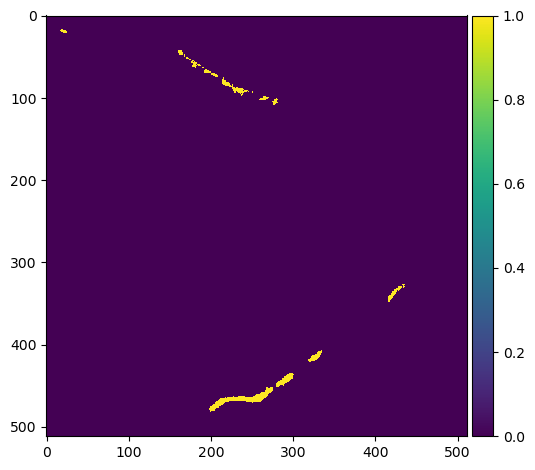

In [54]:
skio.imshow(record_to_np_mask(train_records[0], [13199, 13316, 13433]))

In [41]:
def get_imgs_from_records(record_collection):
    l = []
    for r in record_collection:
        l.append(r.as_dict()['common']['filepath'])
    return l

need to build a fastai data loader that doesn't take img paths and instead tkaes in mem sparse arrays

In [96]:
def get_chps(path): return list(sparse_masks.keys())
def get_lbls(fn): return sparse_masks[fn] # fn is the imge path 

In [50]:
MaskBlock??

Signature: MaskBlock(codes=None)
Source:   
def MaskBlock(codes=None):
    "A `TransformBlock` for segmentation masks, potentially with `codes`"
    return TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodes(codes=codes), batch_tfms=IntToFloatTensor)
File:      ~/miniconda3/envs/fastai2/lib/python3.9/site-packages/fastai/vision/data.py
Type:      function


In [42]:
coco_seg_dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes=codes)),
                 get_items=get_imgs_from_records,
                 splitter=RandomSplitter(),
                 get_y=lambda record: record_to_np_mask(record), 
                 batch_tfms=aug_transforms(),
                 n_inp=1)

NameError: name 'codes' is not defined

## CV1 Parser

In [43]:
mount_path = "/root/data/cv1_transfer/"
ml_data_path = os.path.join(mount_path, "labeled_data")
path = Path(ml_data_path)
oil_chps = np.loadtxt(path/'oil_chps.txt', dtype=str)
codes = np.loadtxt(path/'codes.txt', dtype=str)
valid_names = np.loadtxt(path/'valid_names.txt', dtype=str)

In [44]:
import skimage.io as skio
import numpy as np
import dask

labels = path/"lbl"
labels_no_3 = path/"lbl_no3"

os.makedirs(labels_no_3, exist_ok=True)

vals = set()
lazy_results = []
for i in list(labels.glob("*.png"))[0:100]:
    arr = skio.imread(i)
    values = np.unique(arr)
    # I think this was setting a class we didn't need to 0 
    # for the purposes of recreating Jona's binary classifier
    arr[arr==3] = 0
    try:
        lazy_result = dask.delayed(skio.imsave)(labels_no_3 / i.name, arr, check_contrast=False)
        lazy_results.append(lazy_result)
    except:
        continue
computed_results = dask.compute(*lazy_results)

In [45]:
random.seed(42)
oilless_chps = [chp for chp in get_image_files(path/'chp') if chp.stem not in oil_chps]
density = 0
num_oilless = density * len(oil_chps)
mixed_chps = random.sample(oilless_chps,num_oilless) + [path/'chp'/(chp+'.png') for chp in oil_chps]
len(mixed_chps)

473

In [46]:
codes

array(['Background', 'Oil', 'Coincident'], dtype='<U10')

In [ ]:
def get_chps(path): return mixed_chps
def get_lbls(fn): return fn.parent.parent/"lbl_no3"/f"{fn.name}"
def splitter_func(fn): return fn.name.rsplit('_',1)[0] in valid_names # XXX Check to make sure this should be returning True for Valid

drive_files = get_chps(path)

In [ ]:
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
lcl =  Path('/root/data/experiments/cv1/'+timestampStr+'/')
#lcl = Path("../out_data")
lcl.mkdir(exist_ok=True)
modelpath = lcl

use_lcl = False
if use_lcl:
  path = lcl
  lcl_chp = path/"chp"
  lcl_lbl = path/"lbl_no3"
  lcl_chp.mkdir(exist_ok=True)
  lcl_lbl.mkdir(exist_ok=True)
  for i, f in enumerate(drive_files): # 10 minutes?!
    if not i%50: print(i, f)
    if not (lcl_chp/f.name).exists():
      copyfile(f, lcl_chp/f.name)
    if not (lcl_lbl/f.name).exists():
      copyfile(get_lbls(f), lcl_lbl/f.name)

In [ ]:
seg_db = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=codes)),
    get_items = get_chps,
    splitter=FuncSplitter(splitter_func),
    batch_tfms=augs,
    get_y=get_lbls)

In [ ]:
dls = SegmentationDataLoaders.from_dblock(
    dblock = seg_db,
    source = path,
    path = path,
    bs = 4)

In [ ]:
seg_db.summary(path)

In [ ]:
dls.show_batch(vmin=0, vmax=3)

In [ ]:
# add best model callback saver
# write to drive not lcl

In [ ]:
arch = 18
archs = {18: resnet18, 34: resnet34, 50: resnet50}

In [ ]:
learn = unet_learner(dls, archs[arch], metrics=[Dice()], model_dir=modelpath, cbs=[MixedPrecision])

In [ ]:
lr = learn.lr_find()

In [ ]:
lr

In [ ]:
cbs = [TensorBoardCallback(projector=False, trace_model=False)]


In [ ]:
learn.fine_tune(5, 2e-4, cbs=cbs)#, cbs=SaveModelCallback(monitor='dice'))w

In [ ]:
# learn.load("model")

In [ ]:
learn

In [ ]:
savename = f'{density}_{arch}_{size}_{round(learn.validate()[1],3)}.pkl'
learn.export(f'{modelpath}/{savename}')

In [ ]:
ls {modelpath}

In [ ]:
learn.show_results(max_n=4, figsize=(20,20), vmin=0, vmax=3)

Default path for tensorboard logs is `./runs/`

In [ ]:
!ls './runs/'

Copy logs to appropriate exeriments folder in the mounted GCS volume.

In [ ]:
!cp -R './runs/' {modelpath}'/tensorboard/'

Now, run the following from anywhere with gcs authenticated:

In [ ]:
!tensorboard --logdir="/root/data/experiments/cv1/09_Mar_2022_18_32_17/tensorboard"
